In [1]:
import pandas as pd
import numpy as np

import torch
import numpy as np
import pandas as pd
import pickle
import multiprocessing
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    """ Get a list of index values for Validation set from a dataset

    Arguments:
        n : int, Total number of elements in the data set.
        cv_idx : int, starting index [idx_start = cv_idx*int(val_pct*n)]
        val_pct : (int, float), validation set percentage
        seed : seed value for RandomState

    Returns:
        list of indexes
    """
    np.random.seed(seed)
    n_val = int(val_pct * n)
    idx_start = cv_idx * n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start + n_val]


def split_by_idx(idxs, *a):
    """
    Split each array passed as *a, to a pair of arrays like this (elements selected by idxs,  the remaining elements)
    This can be used to split multiple arrays containing training data to validation and training set.

    :param idxs [int]: list of indexes selected
    :param a list: list of np.array, each array should have same amount of elements in the first dimension
    :return: list of tuples, each containing a split of corresponding array from *a.
            First element of each tuple is an array composed from elements selected by idxs,
            second element is an array of remaining elements.
    """
    mask = np.zeros(len(a[0]), dtype=bool)
    mask[np.array(idxs)] = True
    return [(o[mask], o[~mask]) for o in a]


class AutoEncoder(object):

    def __init__(self, data, validation_perc=0.2, lr=0.001,
                 intermediate_size=1000, encoded_size=100):

        # create training dataloader and validation tensor
        self.data = data
        self.val_idxs = get_cv_idxs(n=data.shape[0], val_pct=validation_perc)
        [(self.val, self.train)] = split_by_idx(self.val_idxs, data)
        self.dataset = AETrainingData(self.train)
        self.dataloader = DataLoader(self.dataset, batch_size=64, shuffle=True,
                                     num_workers=multiprocessing.cpu_count())
        #print('datal=',self.dataloader)
        self.val = torch.from_numpy(self.val.values).\
            type(torch.FloatTensor).cuda()

        # instantiate the encoder and decoder nets
        size = data.shape[1]
        self.encoder = Encoder(size, intermediate_size, encoded_size).cuda()
        self.decoder = Decoder(size, intermediate_size, encoded_size).cuda()

        # instantiate the optimizers
        self.encoder_optimizer = optim.Adam(
            self.encoder.parameters(), lr=lr, weight_decay=1e-8)
        self.decoder_optimizer = optim.Adam(
            self.decoder.parameters(), lr=lr, weight_decay=1e-8)

        # instantiate the loss criterion
        self.criterion = nn.MSELoss(reduction='mean')

        self.train_losses = []
        self.val_losses = []

    def train_step(self, input_tensor, target_tensor):
        # clear the gradients in the optimizers
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        # Forward pass through
        encoded_representation = self.encoder(input_tensor)
        reconstruction = self.decoder(encoded_representation)

        # Compute the loss
        loss = self.criterion(reconstruction, target_tensor)

        # Compute the gradients
        loss.backward()

        # Step the optimizers to update the model weights
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        # Return the loss value to track training progress
        return loss.item()
    
    def reset(self, train=True):
        # due to dropout the network behaves differently in training and
        # evaluation modes
        if train: self.encoder.train(); self.decoder.train()
        else: self.encoder.eval(); self.decoder.eval()

    def get_val_loss(self, input_tensor, target_tensor):
        self.reset(train=False)
        encoded = self.encoder(input_tensor)
        decoded = self.decoder(encoded)
        loss = self.criterion(decoded, target_tensor)
        return loss.item()

    def train_loop(self, epochs, print_every_n_batches=20):

        # Cycle through epochs
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')

            # Cycle through batches
            for i, batch in enumerate(self.dataloader):
                #print(i,batch)
                
                self.reset(train=True)

                input_tensor = batch['input'].cuda()
                target_tensor = batch['target'].cuda()

                loss = self.train_step(input_tensor, target_tensor)

                if i % print_every_n_batches == 0 and i != 0:
                    #print('i=',i)
                    val_loss = self.get_val_loss(self.val, self.val)
                    print(f'train loss: {round(loss, 8)} | ' +
                          f'validation loss: {round(val_loss, 8)}')
                    self.train_losses.append(loss)
                    self.val_losses.append(val_loss)

    def get_encoded_representations(self):
        to_encode = torch.from_numpy(self.data.values).type(
            torch.FloatTensor).cuda()
        self.reset(train=False)
        encodings = self.encoder(to_encode).cpu().data.numpy()
        return encodings


class AETrainingData(Dataset):
    """
    Format the training dataset to be input into the auto encoder.
    Takes in dataframe and converts it to a PyTorch Tensor
    """

    def __init__(self, x_train):
        self.x = x_train

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        """
        Returns a example from the data set as a pytorch tensor.
        """
        # Get example/target pair at idx as numpy arrays
        x, y = self.x.iloc[idx].values, self.x.iloc[idx].values

        # Convert to torch tensor
        x = torch.from_numpy(x).type(torch.FloatTensor)
        y = torch.from_numpy(y).type(torch.FloatTensor)

        # Return pair
        return {'input': x, 'target': y}


class Encoder(nn.Module):
    def __init__(self, input_size, intermediate_size, encoding_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(intermediate_size, encoding_size),
            nn.BatchNorm1d(encoding_size),
            nn.ReLU(True),
            nn.Dropout(0.2))

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, output_size, intermediate_size, encoding_size):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(intermediate_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.Sigmoid())

    def forward(self, x):
        x = self.decoder(x)
        return x


In [2]:
with open(f'tfidf_matrix.pkl', 'rb') as fh:
    tfidf_df1 = pickle.load(fh)

In [3]:
ae2 = AutoEncoder(tfidf_df1, validation_perc=0.1, lr=0.01, intermediate_size=900, encoded_size=100)

In [4]:
ae2.train_loop(epochs=110)

Epoch 1/110
train loss: 0.21472937 | validation loss: 0.15596341
train loss: 0.16717227 | validation loss: 0.13342462
train loss: 0.14014411 | validation loss: 0.14035137
train loss: 0.10104091 | validation loss: 0.1316725
train loss: 0.11404046 | validation loss: 0.08942141
train loss: 0.08856744 | validation loss: 0.07461871
train loss: 0.07254368 | validation loss: 0.06106337
Epoch 2/110
train loss: 0.06312704 | validation loss: 0.04971409
train loss: 0.05640855 | validation loss: 0.04245222
train loss: 0.04224129 | validation loss: 0.03865002
train loss: 0.03779844 | validation loss: 0.03394844
train loss: 0.03495286 | validation loss: 0.03576812
train loss: 0.04523541 | validation loss: 0.03041981
train loss: 0.04708321 | validation loss: 0.03361243
Epoch 3/110
train loss: 0.02850145 | validation loss: 0.02724472
train loss: 0.04153195 | validation loss: 0.02398087
train loss: 0.02710248 | validation loss: 0.02393682
train loss: 0.02551359 | validation loss: 0.02454465
train loss:

In [5]:
losses1 = pd.DataFrame(data=list(zip(ae2.train_losses, ae2.val_losses)), columns=['train_loss', 'validation_loss'])
losses1['epoch'] = (losses1.index + 1) / 3

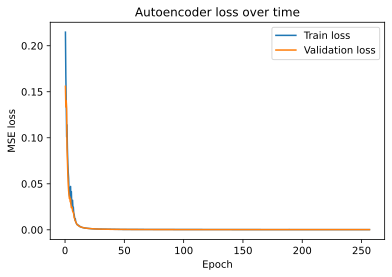

In [6]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(losses1['epoch'], losses1['train_loss'], label="Train loss")
ax.plot(losses1['epoch'], losses1['validation_loss'],label="Validation loss")
ax.set_ylabel('MSE loss')
ax.set_xlabel('Epoch')
ax.set_title('Autoencoder loss over time')
plt.legend()

In [7]:
encoded2 = ae2.get_encoded_representations()

In [8]:
with open('autoencoder_content_embeddings.pkl', 'wb') as fh:
    pickle.dump(encoded2, fh)